In [1]:
# !unzip Yale_Face_Database.zip

## PCA

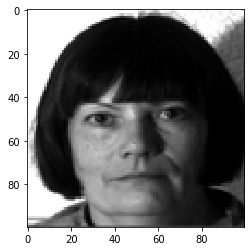

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

HEIGHT = 100
WIDTH = 100

def load_img(path, height=HEIGHT, width=WIDTH):
    label = []
    img_list = []
    for file in os.listdir(f'Yale_Face_Database/{path}'):
        subject = int(file[7:9])
        img = Image.open(f'Yale_Face_Database/{path}/{file}')
        img = img.resize((height,width), Image.ANTIALIAS)
        
        label.append(subject)
        img_list.append(np.array(img).reshape(-1)) # Flatten 100x100 to 10000 features
        plt.imshow(img, cmap='gray')
    return np.array(img_list), np.array(label) #(135,10000) (135,)

img, label = load_img('Training')

## Eigenfaces Reconstruction
[NumPy: difference between linalg.eig() and linalg.eigh()](https://stackoverflow.com/questions/45434989/numpy-difference-between-linalg-eig-and-linalg-eigh)

In [3]:
def PCA(data):
    S = np.cov(data.T) # (10000,135) cov -> (10000,10000)
    eigenvalue, eigenvector = np.linalg.eigh(S)
    idx = np.argsort(eigenvalue)[::-1] # Select the largest k eigenvalue
    idx = idx[:25]
    vector = eigenvector[:,idx] # (10000,25)
    
    return (data @ vector), vector

pca, eigenvector = PCA(img)
recon = pca @ eigenvector.T

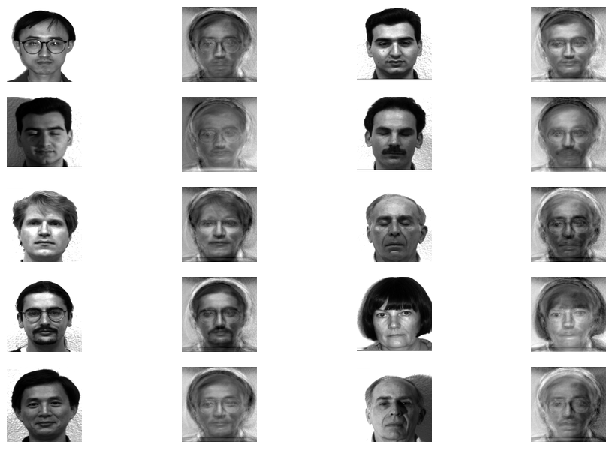

In [4]:
num_sample = 10
rand_idx = np.random.choice(len(img), num_sample, replace=False)
plt.figure(figsize=(12,8))
for i in range(num_sample*2):
    if i%2 == 0:
        plt.subplot(num_sample//2,4,i+1)
        plt.axis('off')
        plt.imshow(img[rand_idx[i//2]].reshape(HEIGHT,WIDTH), cmap='gray')
    else:
        plt.subplot(num_sample//2,4,i+1)
        plt.axis('off')
        plt.imshow(recon[rand_idx[i//2]].reshape(HEIGHT,WIDTH), cmap='gray')
    #plt.tight_layout()

## Face Recognition (KNN)

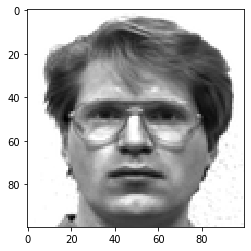

In [5]:
test_x, test_y = load_img('Testing')

pca, eigenvector = PCA(np.concatenate([img, test_x]))
train_pca = pca[:len(img)]
test_pca = pca[len(img):]

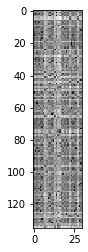

In [6]:
from scipy.spatial.distance import cdist

distance = cdist(train_pca, test_pca)
_ = plt.imshow(distance, interpolation='none', cmap='gray')

k = 1, accuracy = 0.8333333333333334
k = 3, accuracy = 0.8333333333333334
k = 5, accuracy = 0.9
k = 8, accuracy = 0.8333333333333334
k = 10, accuracy = 0.8
k = 12, accuracy = 0.8
k = 15, accuracy = 0.8
k = 20, accuracy = 0.7
k = 50, accuracy = 0.43333333333333335
k = 100, accuracy = 0.3


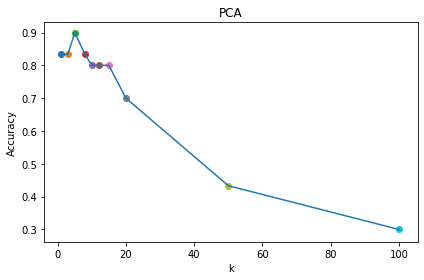

In [7]:
def create_dict():
    dic = {}
    for name in set(label):
        dic[name] = 0
    return dic

create_dict()

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

def KNN(k, train, test, test_label):
    
    acc = 0
    distance = cdist(train, test)

    for i in range(len(test)):
        dic = create_dict()
        idx = np.argsort(distance[:,i])[:k]

        for j in idx:
            dic[label[j]] += 1

        if max(dic, key=dic.get) == test_label[i]:
            acc += 1
                     
    return acc/len(test)


score = []
for i in k_choices:
    acc = KNN(i, train_pca, test_pca, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)

    

plt.plot(k_choices, score)
plt.title('PCA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()

## Kernel PCA
$K^{C}=K-\mathbf{1}_{N} K-K \mathbf{1}_{N}+\mathbf{1}_{N} K \mathbf{1}_{N}$


$1_{N}$ is $N_{\mathrm{X}} N$ matrix with every element $1 / N$
### RBF Kernel

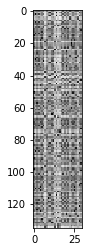

k = 1, accuracy = 0.8
k = 3, accuracy = 0.8666666666666667
k = 5, accuracy = 0.8333333333333334
k = 8, accuracy = 0.8666666666666667
k = 10, accuracy = 0.8666666666666667
k = 12, accuracy = 0.8333333333333334
k = 15, accuracy = 0.8333333333333334
k = 20, accuracy = 0.8
k = 50, accuracy = 0.23333333333333334
k = 100, accuracy = 0.23333333333333334


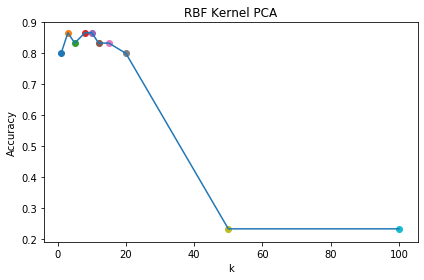

In [10]:
from scipy.spatial.distance import pdist, squareform

def Kernel_PCA(data, method='rbf'):
    
    if method=='rbf':
        gamma = 1e-5
        K = np.exp(-gamma * squareform(pdist(data), 'sqeuclidean')) # (135,135)
        
    elif method=='linear':
        K = data @ data.T # (135,135)
        
        
    one = np.ones_like(K) / K.shape[0]
    K_c = K - one@K - K@one + one@K@one # (135,135)

    eigenvalue, eigenvector = np.linalg.eigh(K_c)
    idx = np.argsort(eigenvalue)[::-1] # Select the largest k eigenvalue
    idx = idx[:25]
    vector = eigenvector[:,idx] # (135,25)

    return (K @ vector), vector # (135,25) (135,25)
    
        

kernel_pca, vector = Kernel_PCA(np.concatenate([img, test_x]), 'rbf')
train_kernel_pca = kernel_pca[:len(img)]
test_kernel_pca = kernel_pca[len(img):]

distance = cdist(train_kernel_pca, test_kernel_pca)
_ = plt.imshow(distance, interpolation='none', cmap='gray') 
plt.show()

score = []
for i in k_choices:
    acc = KNN(i, train_kernel_pca, test_kernel_pca, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)
   

plt.plot(k_choices, score)
plt.title('RBF Kernel PCA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()

### Linear Kernel

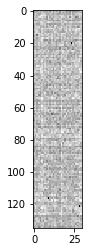

k = 1, accuracy = 0.2
k = 3, accuracy = 0.1
k = 5, accuracy = 0.06666666666666667
k = 8, accuracy = 0.06666666666666667
k = 10, accuracy = 0.06666666666666667
k = 12, accuracy = 0.03333333333333333
k = 15, accuracy = 0.03333333333333333
k = 20, accuracy = 0.06666666666666667
k = 50, accuracy = 0.06666666666666667
k = 100, accuracy = 0.06666666666666667


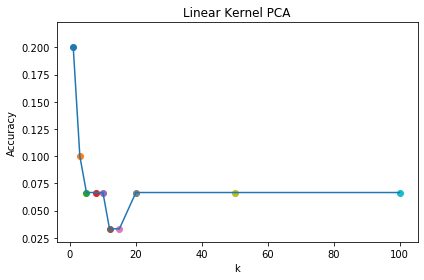

In [11]:
kernel_pca, vector = Kernel_PCA(np.concatenate([img, test_x]), 'linear')
train_kernel_pca = kernel_pca[:len(img)]
test_kernel_pca = kernel_pca[len(img):]

distance = cdist(train_kernel_pca, test_kernel_pca)
_ = plt.imshow(distance, interpolation='none', cmap='gray')
plt.show()

score = []
for i in k_choices:
    acc = KNN(i, train_kernel_pca, test_kernel_pca, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)

    

plt.plot(k_choices, score)
plt.title('Linear Kernel PCA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()